In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
%config InlineBackend.figure_format = 'svg'

plt.rcParams["font.sans-serif"] = 'SimHei'
plt.rcParams["axes.unicode_minus"] = False

# 一台简单的预测机

一台机器可以将千米转化成英里，如下所示：
``` mermaid
    graph LR
    A(千米) --> B[计算]
    B --> C(英里)
```
> **预测器**：上述机器接收一个输入，并做出相应的预测，输出结果，称为预测器。

假如我们不知道千米和英里之间的转换公式，我们所知道的就是，**两者之间的关系是线性的**。
$$
mile = C * kilometer
$$
其中，C为常数，但是我们还不知道这个常数C是多少。

我们所知道的一些对应关系：

| 千米 | 英里 |
| --- | --- |
| 0 | 0 |
| 100 | 62.137 |

**说明：其实我们可以直接用代数法计算出C的值，但我们在此并不这样做。**

那么，我们应该如何计算出常数C呢？  
首先，我们随机生成一个数值，让机器试一下，比如令C=0.5，看看会发生什么。  
**英里 = 0.5 * 100 = 50**
**误差值 = 真实值 - 计算值 = 62.137 - 50 = 12.137**

我们知道错了，并且知道差了多少，所以我们可以使用这个误差，知道我们得到第二个、更好的C。我们知道，增加C就可以增加输出，因为让我们将C从0.5增加到0.6，得到**英里 = 0.6 * 100 = 60**，这个答案比之前更好，误差只有2.137。

由于输出值60还是太小，所以微调C，令C=0.7，此时结果超过了正确答案，误差值为-7.863。因此，我们应该对C进行微调，比如令C=0.61，得到输出值61，误差1.137.

因此，如果输出值越来越接近正确答案，即误差值越来越小，那么我们就不要做那么大的调整。

上面整个过程，其实就是神经网络中学习的核心过程，我们训练机器，使其输出值越来越接近正确答案。我们并非像求解数学一样一步到位，精确求解问题；相反，我们尝试得到一个答案，并多次改进答案，这种方法称为**迭代**，就是持续地、一点一点地改进答案。

# 分类器与预测器并无太大差别

通过测量，可以得到小虫子的宽度和长度，并将其绘制成散点图。

（p8）

可以清楚地看出，毛虫细而长，瓢虫宽而短。

我们可以在图中画一条直线，如果直线可以将毛虫和瓢虫划分开来，那么这条直线就可以根据测量值对未知小虫进行分类。

（p9）

问题在于，我们如何得到正确的斜率呢？如何才能很好地找到划分两种小虫的分界线呢？

# 训练简单的分类器

下表显示了两只小虫：

| 实例 | 宽度 | 长度 | 小虫 |
| --- | --- | --- | --- |
| 1 | 3.0 | 1.0 | 瓢虫 |
| 2 | 1.0 | 3.0 | 毛虫 |

两只小虫

In [30]:
def draw2insects():
    """
    绘制两只已知小虫的散点图
    """
    plt.scatter(1, 3)
    plt.scatter(3, 1)
    
    # xy轴范围
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    
    # 图表注释
    plt.annotate(s = "瓢虫",
                 xy = (1, 3),
                 xytext = (1.5, 2.5),
                 arrowprops=dict(arrowstyle="->"))
    plt.annotate(s = "毛虫",
                 xy = (3, 1),
                 xytext = (3.5, 1.5),
                 arrowprops=dict(arrowstyle="->"))    

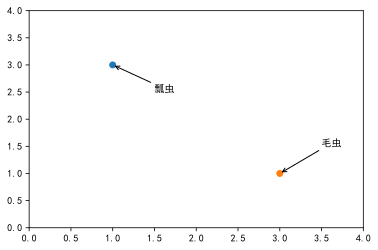

In [32]:
draw2insects()

由于分界线是一条直线，所以我们可以设为：
$$
y = A * x
$$
由于此处的直线并非一台预测器，所以我们使用了y和x，而非长度和宽度。

In [33]:
def insect_classfy(x, a):
    """
    y = a * x
    """
    return a * x

我们先随便假设A = 0.25，分界线为y=0.25x。

In [34]:
a = 0.25
xs = [x for x in range(5)]
ys = [insect_classfy(x, a) for x in xs]

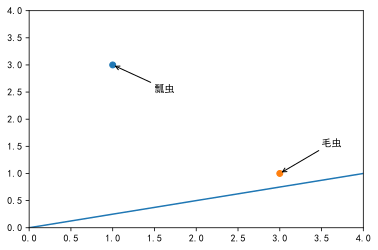

In [35]:
draw2insects()
plt.plot(xs, ys)

我们无需做任何计算即可观察到y=0.25x不是一台和好的分类器，因为这条直线未能将两类昆虫区分开来。直观上我们知道需要将直线往上移动一点，但是我们应该找到一种可复用的算法，而非只适用于这一种情况的。

## 根据第一个实例进行训练

第一个训练样本是宽度为3.0，长度为1.0的瓢虫，如果我们使用这个实例测试函数$y=Ax$，其中$x=3.0$，我们得到：
$y = 0.25 * 3.0 = 0.75$  

这个等式表明，对于宽度为3.0的小虫，其长度应为0.75，但是训练数据告诉我们，这个长度为1.0，因此我们知道这个数字太小了。

而实际上，我们希望直线（分类器）经过瓢虫所在坐标点的上方，也就是$y>1.0$。
因此，当$x=3.0$时，我们令$y=1.1$，当然也可以选择1.2甚至1.3，但是我们不能使用10或100这样较大的数字，因为这会使得直线在瓢虫和毛虫的上方，导致分类器没有任何作用。

因此，期望的目标值是1.1，**误差值E**为：

**误差值 = 期望目标值 - 实际输出值**
$$
E = 1.1 - 0.75 = 0.35
$$

在这个任务中，我们希望通过E来决定参数A所需改变的值，要做到这一点，我们需要知道两者的关系。

**期望值t**称为目标值，为了得到t，我们需要微调A：
$$
t = (A + \Delta{A})x
$$

(p15)
插图

所以，误差值E是期望值减去猜测值，即：
$$
E = t - y 
$$

$$
E = (A + detaA)x - Ax = (deltaA)x
$$

根据上面的公式，我们可以得到如何根据E来调节A：
$$
\Delta{A} = \frac {E} {x}
$$

误差值为0.35，$x=3.0$，使得：
$$
\Delta{A} = \frac {E}{x} = \frac {0.35}{3.0} = 0.1167 
$$

这意味着，修正后的A值为：
$$
A + \Delta{A} = 0.25 + 0.1167 = 0.3667
$$

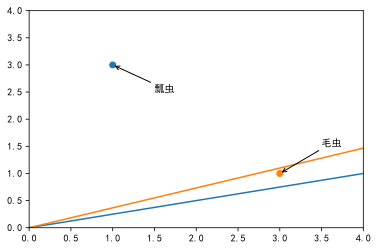

In [36]:
xs = [x for x in range(5)]
ys = [insect_classfy(x, a=0.25) for x in xs]
ys1 = [insect_classfy(x, a=0.3667) for x in xs]

draw2insects()
plt.plot(xs, ys)
plt.plot(xs, ys1)

## 根据第二个实例进行训练

接下来，我们按照第一个实例的训练方法，对第二个实例进行训练。已知正确值为$x = 1.0$和$y = 3.0$。

当使用A = 0.3667，并把x = 1.0代入到线性函数中去，我们得到：
$$
y = 0.3667 * 1.0 = 0.3667
$$
这个结果与训练样本中的y = 3.0相去甚远。基于第一次的推理，我们希望直线不要经过训练数据，而是稍微高于或低于训练数据，我们将目标值设置为2.9.此时，误差值E为：
$$
E = 2.9 - 0.3667 = 2.5333
$$

此时再根据E来改进A：
$$
\Delta{A} = \frac {E}{x} = \frac {2.5333}{1.0} = 2.5333
$$

这意味着$A = 0.3667 + 2.5333 = 2.9$。
（插图）


从上图可以看出，我们每一次训练的结果都是根据最后一次训练样本进行匹配的，并没有考虑到之前的训练样本。

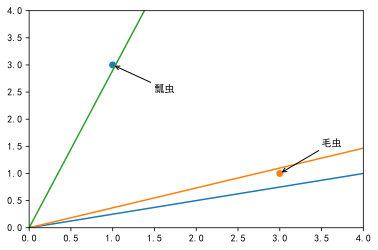

In [38]:
xs = [x for x in range(5)]
ys = [insect_classfy(x, a=0.25) for x in xs]
ys1 = [insect_classfy(x, a=0.3667) for x in xs]
ys2 = [insect_classfy(x, a = 2.9) for x in xs]

draw2insects()
plt.plot(xs, ys)
plt.plot(xs, ys1)
plt.plot(xs, ys2)

## 适度改进（moderate）

为了解决上面遇到的问题，我们可以采用机器学习中的一个重要概念，**适度改进**（moderate）。我们每次只向着训练样本所指示的方向改变一点点，保留先前训练迭代周期中的一部分。

增加一个调节系数L，调节系数通常被称为**学习率**（learning rate）：
$$
\Delta{A} = L \frac {E}{x}
$$

# 分类器的局限性
> 原文：1.5 有时候一个分类器不足以求解问题

**布尔逻辑函数**通常需要两个输入，并输出一个答案。

```mermaid
    graph LR
    A(输入值A) --> C(逻辑函数)
    B(输入值B) --> C
    C --> D(输出)
```

对于`AND`或`OR`函数，我们可以用形如$y = ax + b$的简单线性分类器，将输出结果为True或False给区分开。
（p21图）
（p22图）

但是，对于`XOR`函数，我们没办法用一条简单的直线将两者划分开来。
（p23）

然而，我们可以**使用多个分类器一起工作，来解决这个问题，这就是神经网络的核心思想**。
（p24）

# 神经元——大自然的计算机器

生物大脑中的基本单元——神经元。

**神经元的工作方式**

神经元接受一个电输入，输出另一个电信号。但是，神经元不会立即反应，而是会抑制输入，知道输入增强，强大到达到一个阈值（threshold），才会触发输出。
（p27）

在数学上，有很多激活函数可以模拟上述效果，比如一个简单的**阶跃函数**：
p27

还有**S函数**（sigmoid function）：
p28

我们将使用S函数制造神经网络，S函数有时也称为**逻辑函数**：
$$
y = \frac {1} {1 + e^(-x)}
$$

In [51]:
def sigmoid(x):
    """
    返回sigmoid function的计算结果
    """
    y = 1 / (1 + np.e**(-x))
    return y

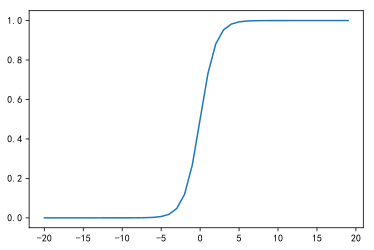

In [54]:
xs = [x for x in range(-20, 20)]
ys = [sigmoid(x) for x in xs]
plt.plot(xs, ys)

**S函数模拟神经元的工作机制**
p29

**自然形式的神经元**
（p30）

**人造模型的神经元**
p30
可以看到三层神经元，每一层有三个人工神经元或节点，每个节点都与前一层或后续层的其他没一个节点相互连接。

接下来的问题是，这个体系架构中：
* 哪一部分能够执行学习功能呢？
* 针对训练样本，我们应该如何调整做出反应呢？
* 有没有和先前线性分类器中类似的参数供我们调整呢？

从上面的神经元结构可以看出，我们有2个部分可以进行调整：
* S阈值函数的形状
* **节点之间的连接强度**

但是，调节节点之间连接强度远比调节S阈值函数的形状简单得多，我们只需要为连接加上**权重**即可，因此我们选择了调节节点之间的连接强度。
（p31）


# 在神经网络中追踪信号

我们先尝试使用只有两层、每层两个神经元的较小的神经网络，来演示神经网络如何工作。
p33

先设定2个输入值，再随机生成4个权重，如下图：
p34

## 第一层

第一层节点是输入层，不做任何计算。

## 第二层

### 第一个节点

第二层第一个节点：
$$
\begin{split}
x_1 &= 1.0 * 0.9 + 0.5 * 0.3 \\
&= 1.05
\end{split}
$$
因此，第一个输出为：
$$
y_1 = \frac {1} {1 + 0.3499} = 0.7408
$$

### 第二个节点

第二层的第二个节点：
$$
x_2 = 1.0 * 0.2 + 0.5 * 0.8 = 0.6
$$
因此，第二个输出为：
$$
y_2 = \frac {1} {1 + 0.5488} = 0.6457
$$

p36

# 矩阵乘法
> 原文：1.8 凭心而论，矩阵乘法大有用途

前面的两层、每一层只有两节点的神经网络进行计算，对于人类而言，工作量已经足够大了。因此，我们需要**使用矩阵帮助我们简化计算**。

**矩阵乘法的运算规则**
> 此处所说的矩阵乘法表示**点乘**（dot product）或**内积**（inner product）。

$$
\begin{pmatrix}
a & b \\
c & d
\end{pmatrix}
\begin{pmatrix}
e & f \\
g & h
\end{pmatrix}
=
\begin{pmatrix}
ae+bg & af+bh \\
ce+dg & cf+dh
\end{pmatrix}
$$

我们将矩阵中的字母替换成对神经网络更有意义的单词：
$$
\begin{pmatrix}
W_{1,1} & W_{2,1} \\
W_{1,2} & W_{2,2}
\end{pmatrix}
\begin{pmatrix}
input_1 \\
input_2
\end{pmatrix}
=
\begin{pmatrix}
W_{1,1} * input_1 + W_{2,1} * input_2 \\
W_{1,2} * input_1 + W_{2,2} * input_2
\end{pmatrix}
$$

上面的矩阵相乘结果正好对应了之前的两层神经网络：
p42

所以，两层神经网络的计算过程可以简洁地表示为：
$$
X = W \cdot I
$$
> W是权重矩阵，I是输入矩阵，X是组合调节后的信号，即输入到第二层的结果矩阵。

因此，来自第二层的最终输出是：
$$
O = sigmoid(X)
$$
> 矩阵O包含了神经网络的最后一层中的所有输出。

# 使用矩阵乘法的三层神经网络示例

如图所示三层神经网络：
p44

第一层为**输入层**，最后一层为**输出层**，中间层为**隐藏层**。

## 输入层

**输入矩阵I**为：
$$
I = 
\begin{pmatrix}
0.9 \\
0.1 \\
0.8
\end{pmatrix}
$$

In [73]:
I = np.mat([0.9, 0.1, 0.8]).T

In [74]:
I

matrix([[0.9],
        [0.1],
        [0.8]])

## 隐藏层

输入层和隐藏层之间的**权重矩阵W**为：
$$
W_{InputHidden} = 
\begin{pmatrix}
0.9 & 0.3 & 0.4 \\
0.2 & 0.8 & 0.2 \\
0.1 & 0.5 & 0.6
\end{pmatrix}
$$
> 注意：以上权重是随机列举的，并无特殊含义。

In [68]:
W_input_hidden = np.mat([[0.9, 0.3, 0.4],
                         [0.2, 0.8, 0.2],
                         [0.1, 0.5, 0.6]])

In [69]:
W_input_hidden

matrix([[0.9, 0.3, 0.4],
        [0.2, 0.8, 0.2],
        [0.1, 0.5, 0.6]])

隐藏层和输出层之间的**权重矩阵W**为：
$$
W_{HiddenOutput} = 
\begin{pmatrix}
0.3 & 0.7 & 0.5 \\
0.6 & 0.5 & 0.2 \\
0.8 & 0.1 & 0.9
\end{pmatrix}
$$

In [70]:
W_hidden_output = np.mat([[0.3, 0.7, 0.5],
                          [0.6, 0.5, 0.2],
                          [0.8, 0.1, 0.9]])

In [71]:
W_hidden_output

matrix([[0.3, 0.7, 0.5],
        [0.6, 0.5, 0.2],
        [0.8, 0.1, 0.9]])

### 输入层到隐藏层

输入到隐藏层的输入值为：
$$
\begin{split}
X_{hidden} &= W_{InputHidden} \cdot I \\
 &= 
 \begin{pmatrix}
0.9 & 0.3 & 0.4 \\
0.2 & 0.8 & 0.2 \\
0.1 & 0.5 & 0.6
\end{pmatrix}
\cdot
\begin{pmatrix}
0.9 \\
0.1 \\
0.8
\end{pmatrix} \\
&=
\begin{pmatrix}
1.16 \\
0.42 \\
0.62
\end{pmatrix}
\end{split}
$$

In [75]:
X_hidden = W_input_hidden * I
X_hidden

matrix([[1.16],
        [0.42],
        [0.62]])

应用S激活函数：
$$
\begin{split}
O_{hidden} &= sigmoid(X_{hidden}) \\
&= sigmoid
\begin{pmatrix}
1.16 \\
0.42 \\
0.62
\end{pmatrix} \\
&=\begin{pmatrix}
0.761 \\
0.603 \\
0.650
\end{pmatrix}
\end{split}
$$

In [76]:
# sigmoid函数应该怎么写，才能运算矩阵？？？？
O_hidden = sigmoid(X_hidden)
O_hidden

TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'matrix'

此时，神经网络应该变成：

p48

### 隐藏层到输出层

不管是多少层神经网络，所有的操作都是一样，组合输入信号、应用链接权重调节输入信号、应用激活函数，生成这些层的输出信号。

$$
\begin{split}
X_{output} &= W_{HiddenOutput} \cdot O_{hidden} \\
 &= 
 \begin{pmatrix}
0.3 & 0.7 & 0.5 \\
0.6 & 0.5 & 0.2 \\
0.8 & 0.1 & 0.9
\end{pmatrix}
\cdot
\begin{pmatrix}
0.761 \\
0.603 \\
0.650
\end{pmatrix} \\
&=
\begin{pmatrix}
0.975 \\
0.888 \\
1.254
\end{pmatrix}
\end{split}
$$

更新神经网络示意图：

p49